## What is image segmentation?

In an image classification task, the network assigns a label (or class) to each input image. However, suppose you want to know the shape of that object, which pixel belongs to which object, etc. In this case, you need to assign a class to each pixel of the image-this task is known as image segmentation.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from zipfile import ZipFile
from PIL import Image
import glob

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
seed = 666

np.random.seed(seed)
tf.random.set_seed(seed)

## Loading the data

In [3]:
with ZipFile('../input/carvana-image-masking-challenge/train.zip', 'r') as zf:
    zf.extractall('../working')

with ZipFile('../input/carvana-image-masking-challenge/train_masks.zip', 'r') as zf:
    zf.extractall('../working')

View the image

Format: JPEG
Size: (1918, 1280)
Mode: RGB


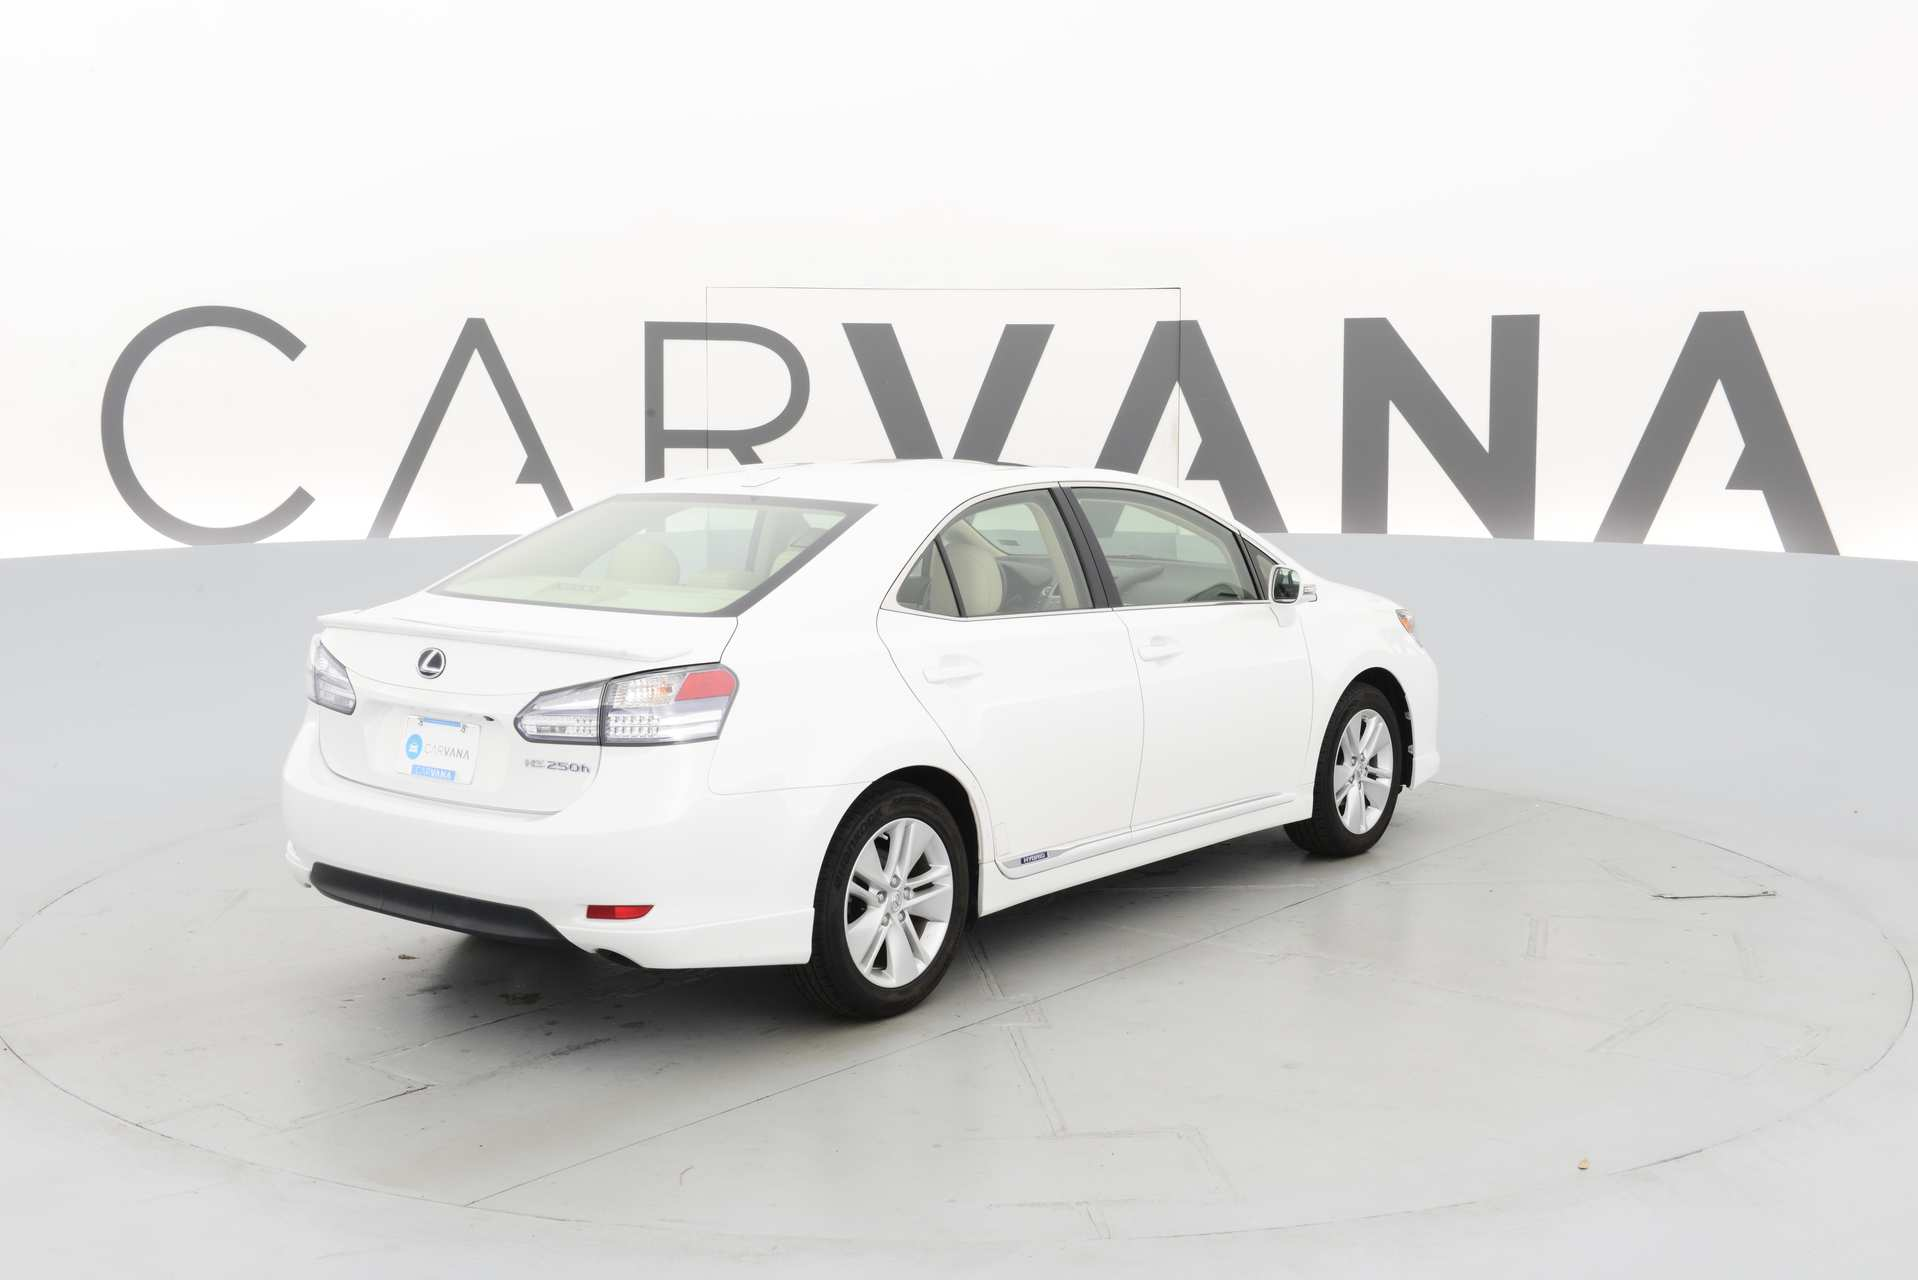

In [4]:
img = Image.open('/kaggle/working/train/151c7f2d4183_11.jpg')
# get the image format (JPEG, PNG, etc.)
print('Format:', img.format)
# get the image size (width, height)
print('Size:', img.size)
# get the image mode (RGB, CMYK, etc.)
print('Mode:', img.mode)
img

Format: GIF
Size: (1918, 1280)
Mode: P


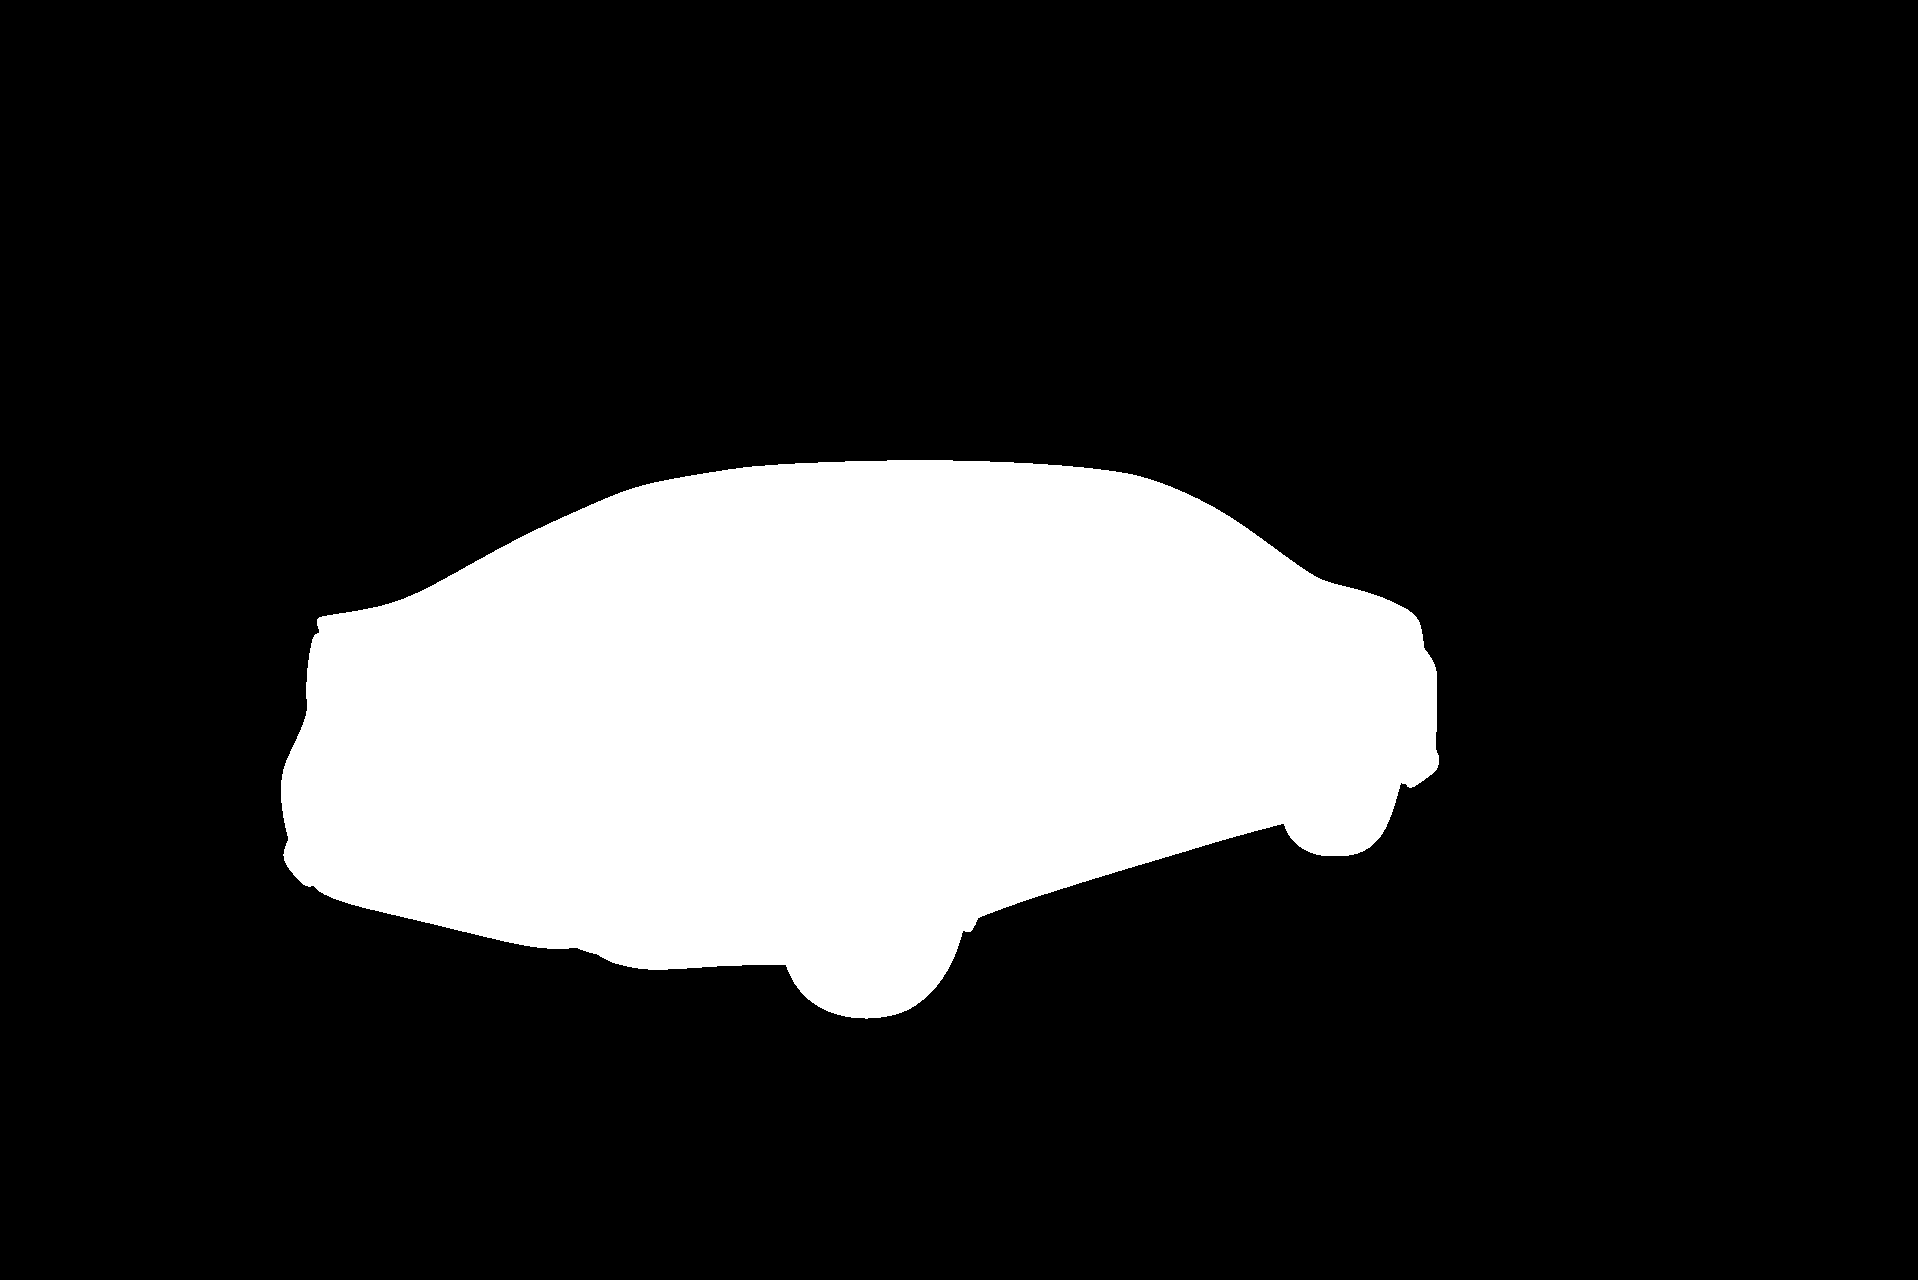

In [5]:
mask_img = Image.open('/kaggle/working/train_masks/151c7f2d4183_11_mask.gif')
# get the image format (JPEG, PNG, etc.)
print('Format:', mask_img.format)
# get the image size (width, height)
print('Size:', mask_img.size)
# get the image mode (RGB, CMYK, etc.)
print('Mode:', mask_img.mode)
mask_img

In [6]:
import os
path = os.path.join('/kaggle/working/train/')
os.listdir(path)[:5]

['c4ac16c0dd59_11.jpg',
 '8d1a6723c458_09.jpg',
 '26ccab021981_04.jpg',
 'feaf59172a01_10.jpg',
 '48b3f0c936b5_14.jpg']

## Preprocessing 

In [7]:
import tensorflow as tf
import os
import shutil

# set the directories for the image files
root_dir = '/kaggle/working/'
file_path = root_dir + 'train/*.*'
file_mask_path = root_dir + 'train_masks/*.*'
image_file = sorted(glob.glob(file_path))
mask_file = sorted(glob.glob(file_mask_path))

img_dir = image_file
seg_dir = mask_file

# create a dataset from the file paths and labels
dataset = tf.data.Dataset.from_tensor_slices((img_dir, seg_dir))

# define e a function to load and preprocess the images and segmentation images
def load_image(file_path, seg_path):
    # load the image file
    img = tf.io.read_file(file_path)
    # decode the image file
    img = tf.image.decode_jpeg(img, channels=3)
    # preprocess the image (e.g. resize, normalize, etc.)
    img = tf.image.resize(img, [256, 256])
    img = tf.cast(img, tf.float32) / 255.0
    
    # load the segmentation image file
    seg = tf.io.read_file(seg_path)
    # decode the segmentation image file
    seg = tf.squeeze(tf.io.decode_gif(seg), axis=0)
    # preprocess the segmentation image (e.g. resize, normalize, etc.)
    seg = tf.image.resize(seg, [256, 256])
    seg = tf.cast(seg, tf.float32) / 255.0
    return img, seg

# map the load_image function to the dataset
dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

# define the batch size and shuffle the dataset
batch_size = 64

# define the size of the validation set as a fraction of the total dataset size
val_size = 0.2

# calculate the number of validation examples
val_size = int(len(img_dir) * val_size)

# shuffle the dataset
dataset = dataset.shuffle(buffer_size=1000)

# split the dataset into training and validation datasets
val_dataset = dataset.take(val_size)
train_dataset = dataset.skip(val_size)

### View the image after preprocess

#### RAW data

In [8]:
it = iter(train_dataset)
a = next(it)

(256, 256, 3)


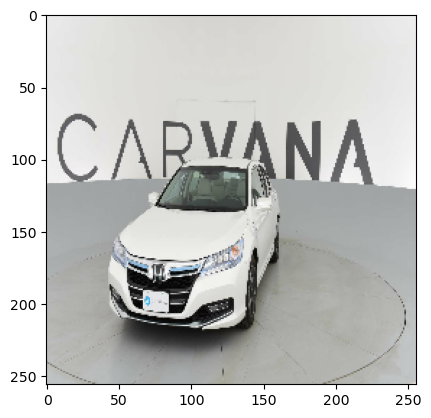

In [9]:
post_img = a[0].numpy()
print(post_img.shape)
plt.imshow(post_img)

#### SEG data

(256, 256, 3)


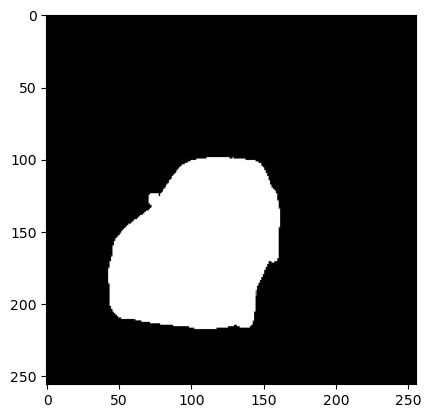

In [10]:
post_seg_img = a[1].numpy()
print(post_seg_img.shape)
plt.imshow(post_seg_img)

In [11]:
class Augment(keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        self.augment_inputs = keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = keras.layers.RandomFlip(mode="horizontal", seed=seed)
        
    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

In [12]:
train_batches = (
    train_dataset
    .shuffle(1000)
    .batch(batch_size)
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

val_batches = val_dataset.batch(batch_size)

In [13]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

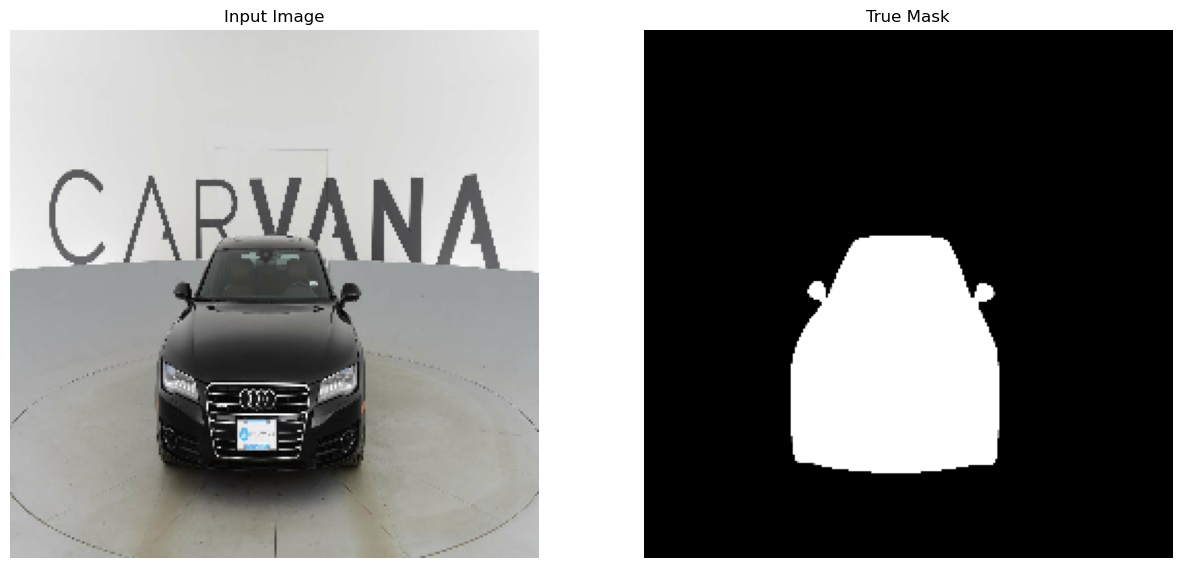

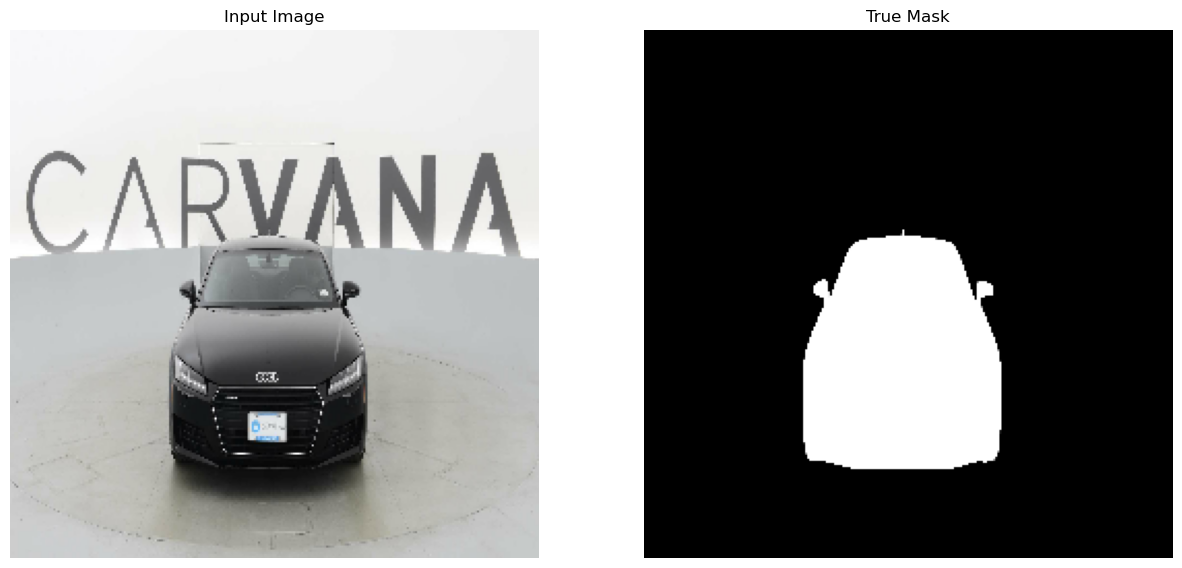

In [14]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

## Define the model

The model being used here is a modified U-Net. A U-Net consists of an ecoder (downsampler) and decoder (upsampler). 

### U-Net
U-Net is a convolutional neural network (CNN) architecture that is commonly used for biomedical image segmentation. It is a fully convolutional network, which means that it has no fully connected layers. This makes it well-suited for image segmentation tasks, as it can learn to segment images at the pixel level.

U-Net has two main parts: an encoder and a decoder. The encoder is responsible for extracting features from the input image, while the decoder is responsible for reconstructing the output image. The encoder consists of a series of convolutional layers, followed by max pooling layers. The decoder consists of a series of upsampling layers, followed by convolutional layers.

U-Net is a powerful architecture that has been shown to be effective for a variety of biomedical image segmentation tasks. It is easy to train and can be used to segment images of different sizes.

![unet](https://blog.paperspace.com/content/images/size/w1000/2021/05/image-26.png)


### U-Net model architecture

In [15]:
# define the encoder block
def encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = tf.random_normal_initializer(0.02, seed=seed)
    # add downsampling layer
    g = layers.Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same',
                     kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = layers.BatchNormalization()(g, training=True)
    # leaky relu activation
    g = layers.LeakyReLU(alpha=0.2)(g)
    return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = tf.random_normal_initializer(stddev=0.02, seed=seed)
    # add upsampling layer
    g = layers.Conv2DTranspose(n_filters, (4, 4), strides=(2, 2), padding='same',
                              kernel_initializer=init)(layer_in)
    # add batch normalization
    g = layers.BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = layers.Dropout(0.3)(g, training=True)
    # merge with skip connection
    g = layers.Concatenate()([g, skip_in])
    g = layers.Activation('relu')(g)
    return g

# define the U-Net model
def UNet(image_shape=(256, 256, 3)):
    # weight initialization
    init = tf.random_normal_initializer(stddev=0.02, seed=seed)
    # image input
    in_image = keras.Input(shape=image_shape)
    
    # encoder model: C64-C128-C256-C512-C512-C512-C512-C512
    e1 = encoder_block(in_image, 64, batchnorm=False)
    e2 = encoder_block(e1, 128)
    e3 = encoder_block(e2, 256)
    e4 = encoder_block(e3, 512)
    e5 = encoder_block(e4, 512)
    e6 = encoder_block(e5, 512)
    e7 = encoder_block(e6, 512)
    
    # bottleneck, no batch norm and relu
    b = layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(e7)
    b = layers.Activation('relu')(b)
    
    # decoder model: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    
    # output 
    g = layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d7)
    out_image = layers.Activation('sigmoid')(g)
    model = keras.Model(in_image, out_image)
    return model

image_shape = (256, 256, 3)
model = UNet(image_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  3136        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 128, 128, 64  0           ['conv2d[0][0]']                 
                                )                                                             

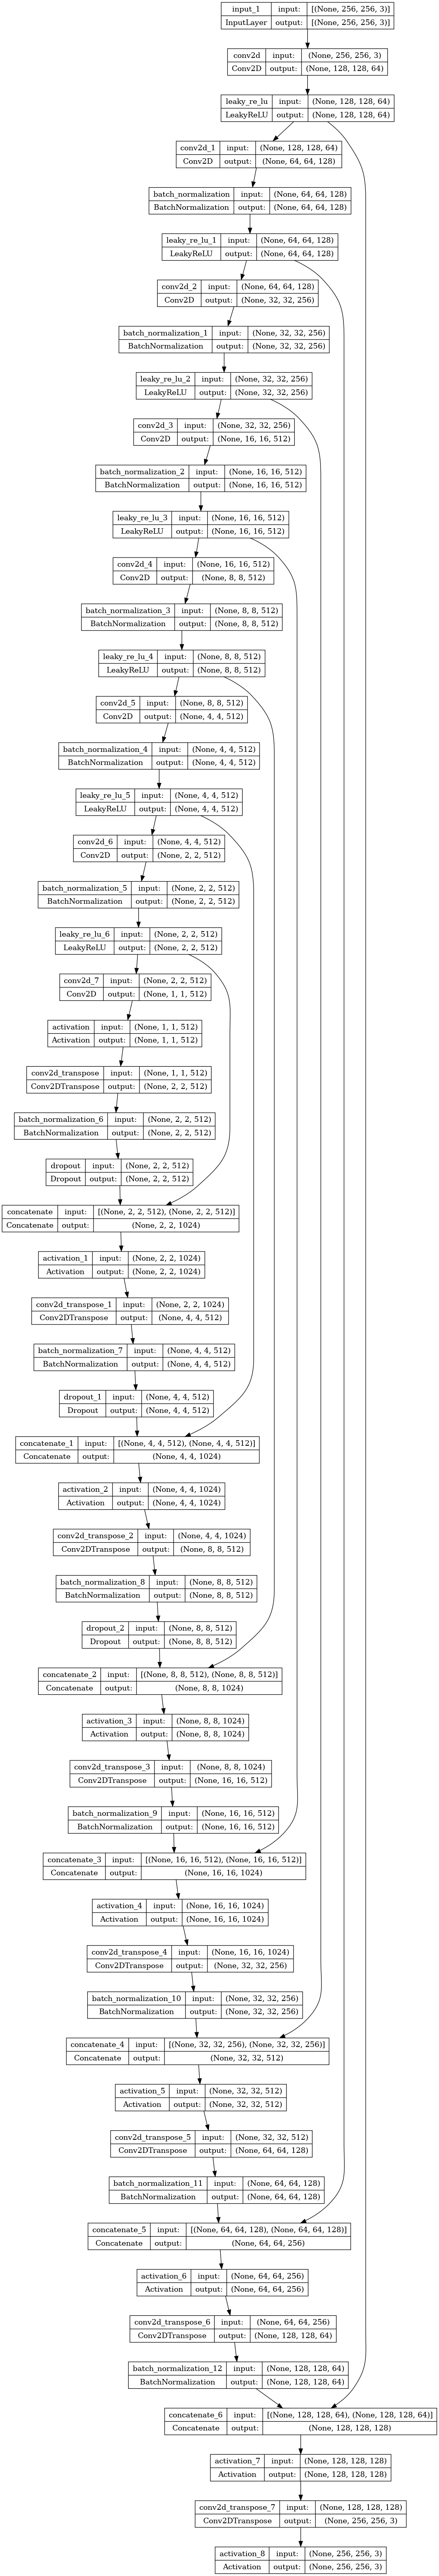

In [16]:
keras.utils.plot_model(model, to_file="UNet.png", show_shapes=True, show_layer_names=True)

## Metrics

**Dice Score:** Dice score, also known as the Sørensen–Dice coefficient, is a statistical measure of the similarity between two sets of data. It is commonly used in image segmentation to evaluate the performance of an algorithm by comparing the algorithm's output to a ground truth.

The Dice score ranges from 0 to 1, where 0 indicates no overlap between the two sets and 1 indicates perfect overlap. The formula for calculating the Dice score is:

`2 * |A ∩ B| / (|A| + |B|)`

where A and B are the two sets being compared, |A| and |B| are the sizes of the sets, and |A ∩ B| is the size of the intersection of the sets.

In image segmentation, A and B are typically binary masks representing the algorithm's output and the ground truth, respectively. The Dice score measures the overlap between the two masks, with higher scores indicating better performance.

The Dice score is a popular evaluation metric in medical image analysis, where it is used to evaluate the accuracy of algorithms for segmenting organs and tumors. It is also used in other fields, such as computer vision and natural language processing, to evaluate the performance of machine learning models.


___________________________________________________________
**IoU Score:** The Intersection over Union (IoU) score is another statistical measure commonly used in image segmentation to evaluate the performance of an algorithm by comparing the algorithm's output to a ground truth. The IoU score is also known as the Jaccard index.

The IoU score measures the overlap between two sets of data, similar to the Dice score. However, the IoU score is calculated as the ratio of the intersection of the sets to the union of the sets, rather than the ratio of the intersection to the sum of the sets. The formula for calculating the IoU score is:

`|A ∩ B| / |A ∪ B|`

where A and B are the two sets being compared, |A ∩ B| is the size of the intersection of the sets, and |A ∪ B| is the size of the union of the sets.

In image segmentation, A and B are typically binary masks representing the algorithm's output and the ground truth, respectively. The IoU score measures the overlap between the two masks, with higher scores indicating better performance.

The IoU score is often used in conjunction with the Dice score to evaluate the performance of image segmentation algorithms. While the Dice score is more sensitive to small differences between the sets, the IoU score is more robust to differences in the sizes of the sets.



In [17]:
def dice_score(y_true, y_pred, smooth=1):
    # flatten the true and predicted masks
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    # calculate the intersection and union of the masks
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)

    # calculate the Dice score
    dice = (2.0 * intersection + smooth) / (union + smooth)

    return dice

def iou_score(y_true, y_pred, smooth=1):
    # flatten the true and predicted masks
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    # calculate the intersection and union of the masks
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)

    # calculate the IoU score
    iou = (intersection + smooth) / (union + smooth)

    return iou

## Compile and Train 

In [18]:
# compile the model with the evaluation metrics
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[dice_score, iou_score])

In [19]:
# train the model and monitor the evaluation metrics
history = model.fit(train_batches, epochs=20, validation_data=val_batches)

Epoch 1/20


2023-07-08 07:48:19.941873: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/64 [==============================] - ETA: 0s - loss: 0.3537 - dice_score: 0.4436 - iou_score: 0.2218

2023-07-08 07:51:02.794544: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/64 [==============================] - 215s 2s/step - loss: 0.3537 - dice_score: 0.4436 - iou_score: 0.2218 - val_loss: 0.1936 - val_dice_score: 0.6836 - val_iou_score: 0.3418
Epoch 2/20
64/64 [==============================] - 188s 2s/step - loss: 0.1285 - dice_score: 0.7998 - iou_score: 0.3999 - val_loss: 0.0690 - val_dice_score: 0.9006 - val_iou_score: 0.4503
Epoch 3/20
64/64 [==============================] - 186s 2s/step - loss: 0.0527 - dice_score: 0.9220 - iou_score: 0.4610 - val_loss: 0.0460 - val_dice_score: 0.9344 - val_iou_score: 0.4672
Epoch 4/20
64/64 [==============================] - 188s 2s/step - loss: 0.0395 - dice_score: 0.9422 - iou_score: 0.4711 - val_loss: 0.0401 - val_dice_score: 0.9438 - val_iou_score: 0.4719
Epoch 5/20
64/64 [==============================] - 187s 2s/step - loss: 0.0309 - dice_score: 0.9547 - iou_score: 0.4773 - val_loss: 0.0285 - val_dice_score: 0.9587 - val_iou_score: 0.4793
Epoch 6/20
64/64 [==============================] - 187s 2s/step -

In [20]:
def show_predictions(dataset=val_batches):
    if dataset:
        for image, mask in dataset.take(5):
          pred_mask = model.predict(image)
          display([image[0], mask[0], pred_mask[0]])

2023-07-08 08:55:28.261915: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2/2 [==============================] - 2s 14ms/step


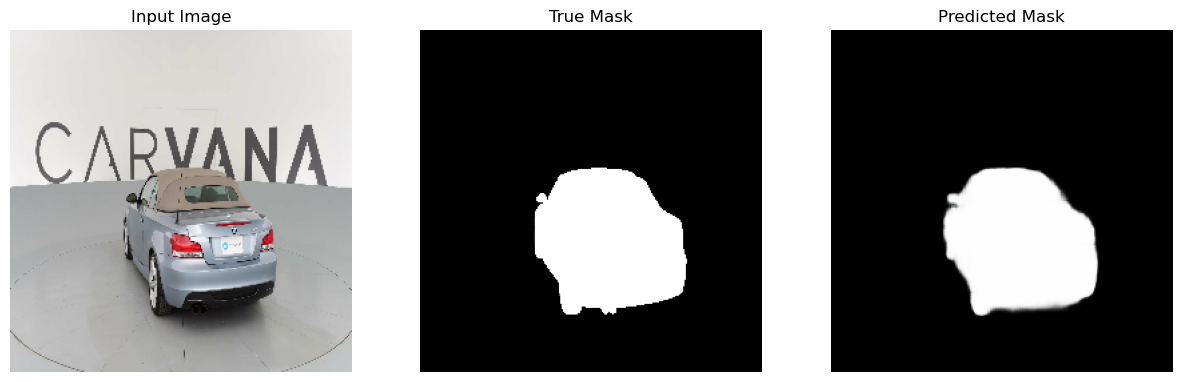

2/2 [==============================] - 0s 96ms/step


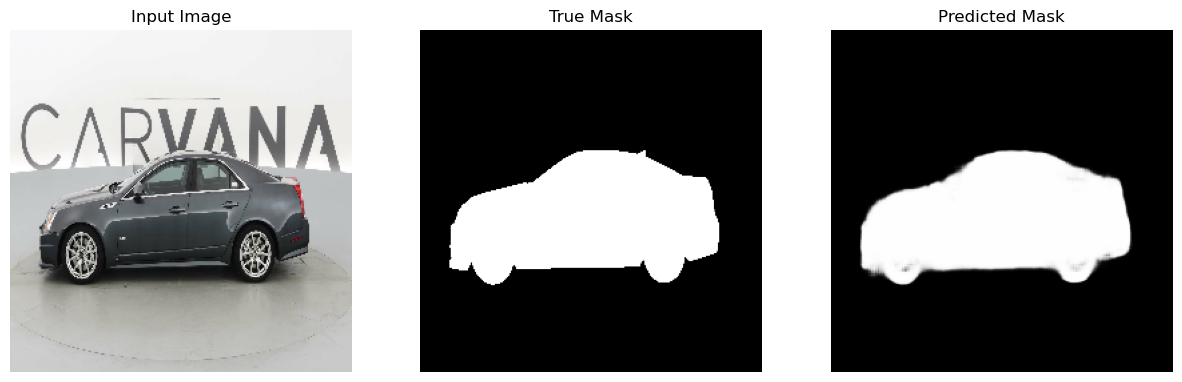

2/2 [==============================] - 0s 96ms/step


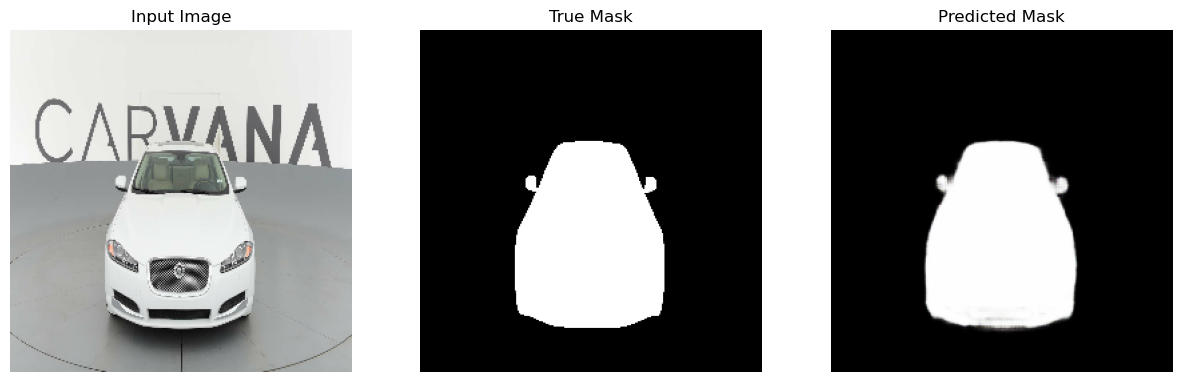

2/2 [==============================] - 0s 110ms/step


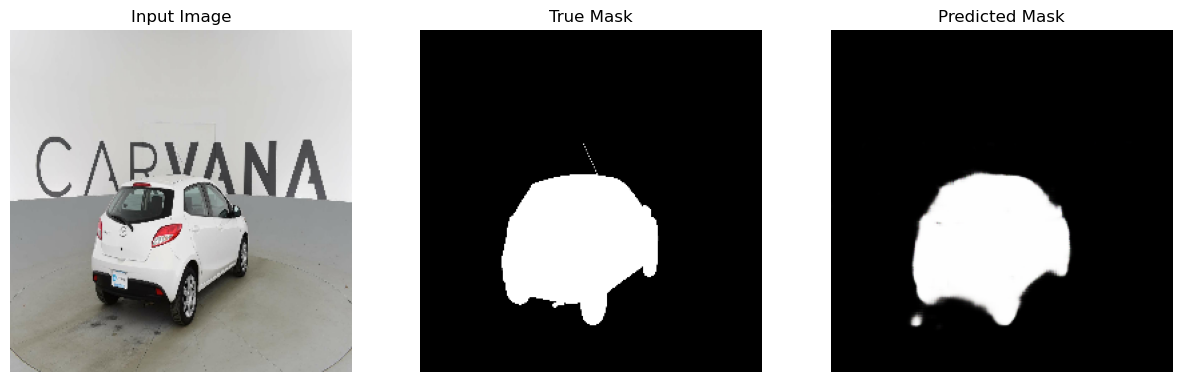

2/2 [==============================] - 0s 95ms/step


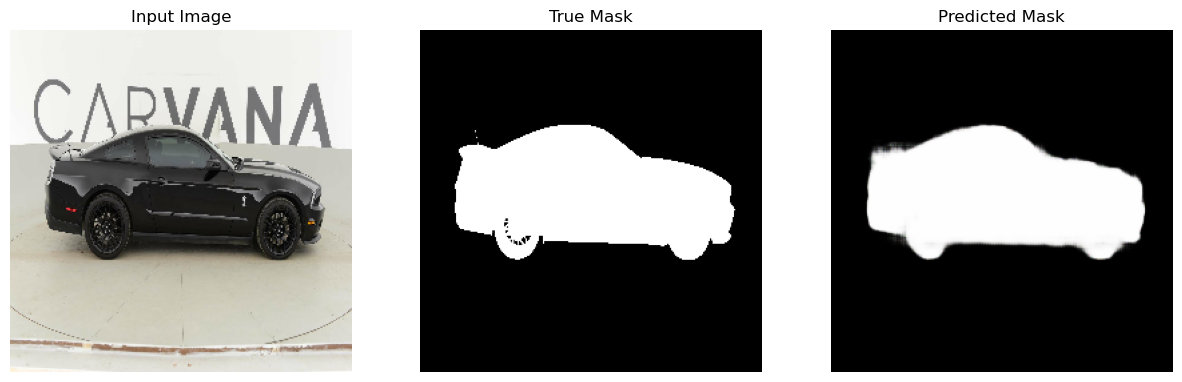

In [21]:
show_predictions()

In [22]:
model.save("carvana-unet.h5")